In [3]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import time
import pandas as pd
import os

from shapely.geometry import Point, Polygon

/tmp/ipykernel_27899/2703596994.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(poly.area)


0    0.025301
dtype: float64


<Axes: >

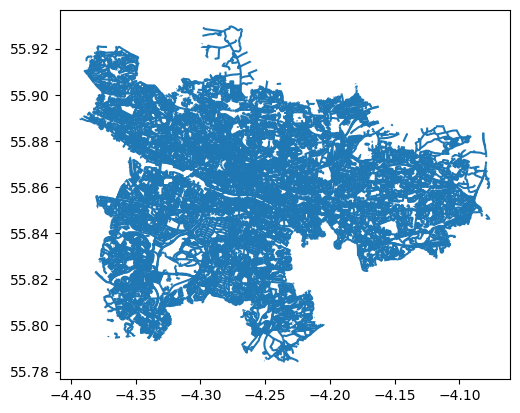

In [6]:
cdir = os.getcwd() 
path = os.path.dirname(cdir) + "/geojson_polygons"

poly = gpd.read_file(f"{path}/glasgow.geojson")#.to_crs(3857)#.buffer(3000,join_style=2).to_crs(4326))

print(poly.area)
# features_from_bbox takes bbox as [north, south, east, west]
# so a reorder of total_bounds is needed (it goes minx, miny, maxx, maxy)
bb = poly.total_bounds
bb[0], bb[1], bb[2], bb[3] = bb[3], bb[1], bb[2], bb[0] 

tags = {"highway" : True}
#tags = {"highway" : True, "railway" : True, "waterway" : True}
ways = ox.features_from_bbox(bbox=bb, tags=tags)
ways = ways.loc[ways.geometry.type=='LineString']
ways = ways.loc[ways.highway!="footway"]
ways_clip = gpd.clip(ways, poly)

In [9]:
glasgow_pd = gpd.read_file(f"{path}/glasgow_polling_districts.geojson")

print(glasgow_pd)

     OBJECTID POLLING_DISTRICT                  POLLING_STATION  \
0           1           AN1713       Knightswood Baptist Church   
1           2           CC1701      John Paul II Primary School   
2           3           CC1801        Carmunnock Primary School   
3           4           PK3204          Mosspark Primary School   
4           5           PR1022  Alexandra Parade Primary School   
..        ...              ...                              ...   
259       260           SH2209                  Reidvale Centre   
260       261           MS4616    Possilpark Parish Church Hall   
261       262           KE3110        St Mungo's Primary School   
262       263           KE3210             The Burgh Court Hall   
263       264           PK3504     Cardonald Parish Church Hall   

             STATION_ADDRESS POSTCODE  \
0       181 Knightswood Road  G13 2XL   
1           29 Dunagoil Road  G45 9UR   
2         158 Waterside Road  G76 9AJ   
3         20 Mosspark Square  G

<function matplotlib.pyplot.show(close=None, block=None)>

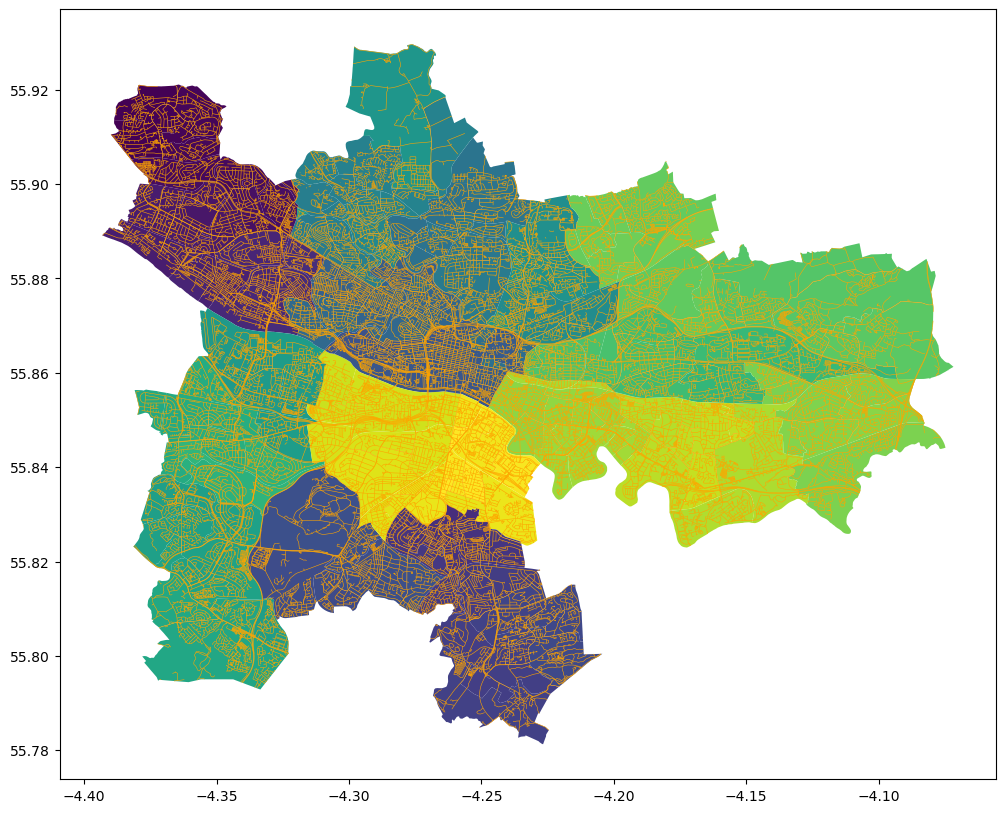

In [15]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

ways_clip.plot(ax=ax, linewidth=0.4, edgecolor='orange')
glasgow_pd.plot(ax=ax, column='POLLING_DISTRICT', cmap='viridis')#facecolor='none', edgecolor='orange')
plt.show
